# Projet Deep Learning
by Thomas ODIN, Maïa JOUENNE et Benoit CATEZ

## Import et telechargement des paquets necessaires

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

/home/todin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-02-27 12:09:49.192141: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 12:09:49.230618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 12:09:49.230653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 12:09:49.231790: E external/local_xla/xla/stream_e

## 1) Classification

### Crop and annotation

Number of valid cropped images: 2075
Number of proposed images: 2077
Image sizes:
(106, 169, 3)    6
(70, 64, 3)      6
(43, 72, 3)      4
(2, 1, 3)        4
(131, 262, 3)    4
                ..
(93, 56, 3)      1
(87, 41, 3)      1
(72, 70, 3)      1
(51, 61, 3)      1
(53, 84, 3)      1
Name: cropped_image, Length: 1023, dtype: int64


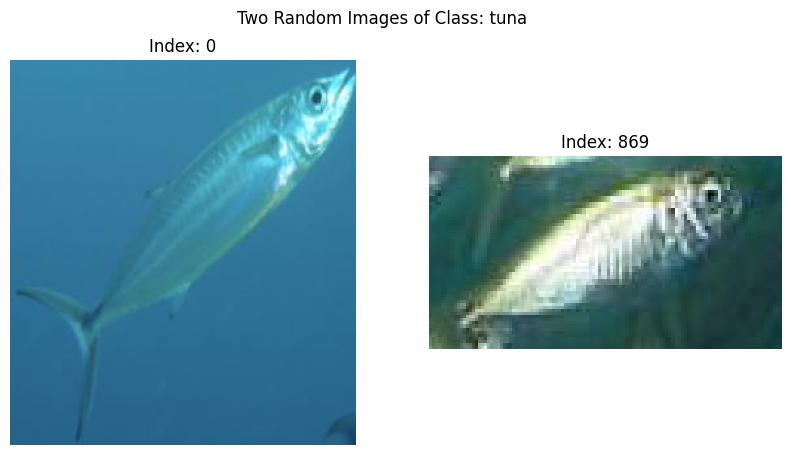

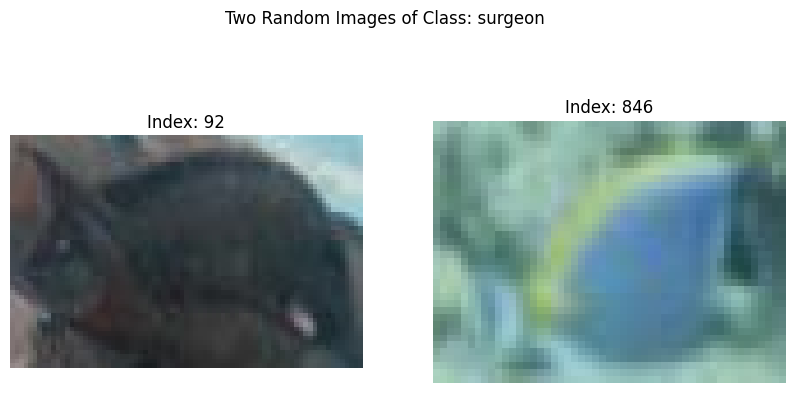

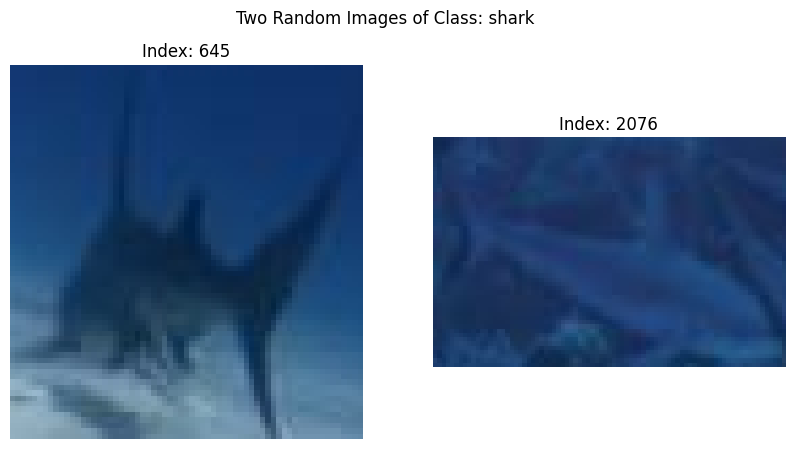

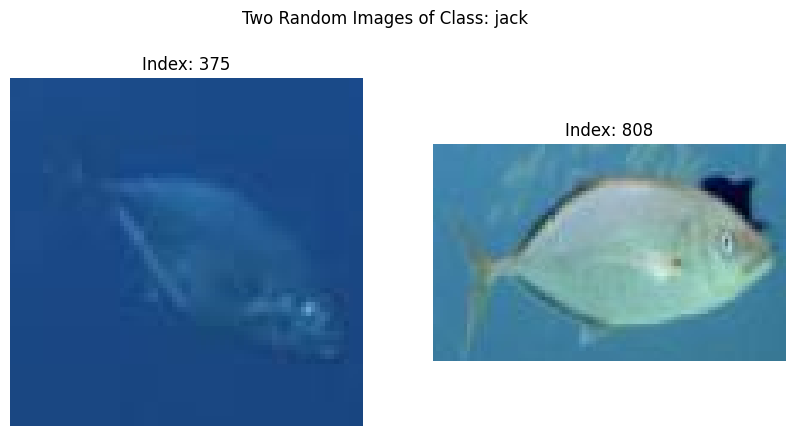

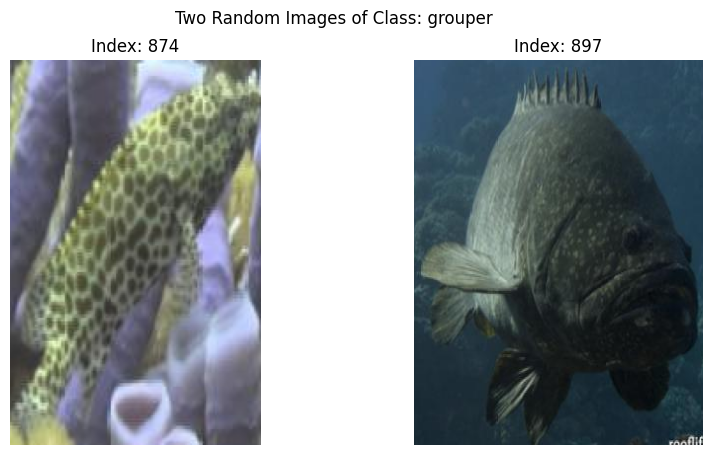

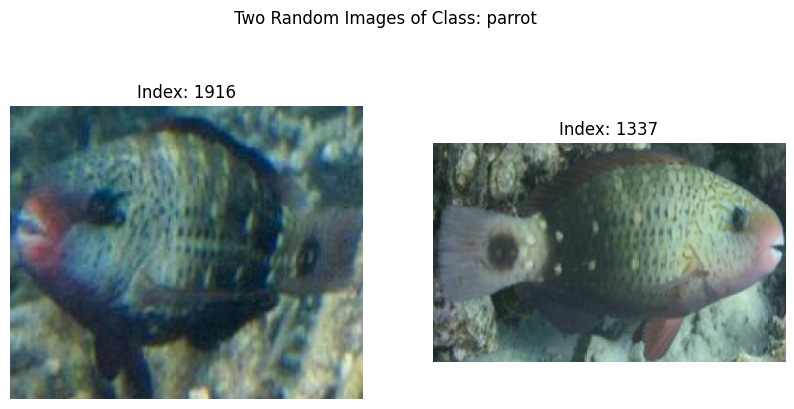

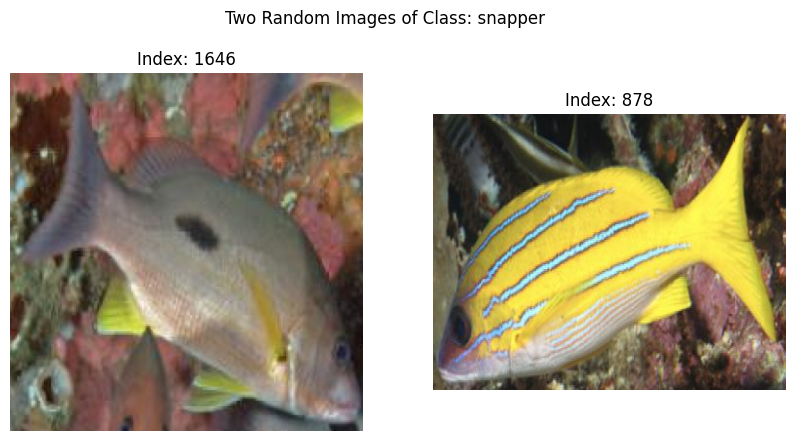

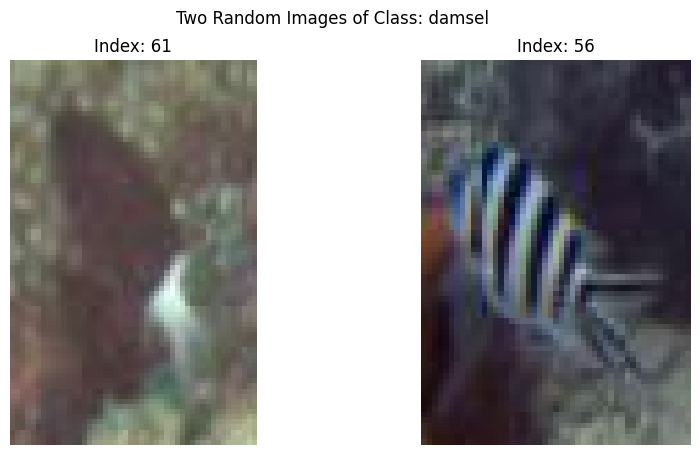

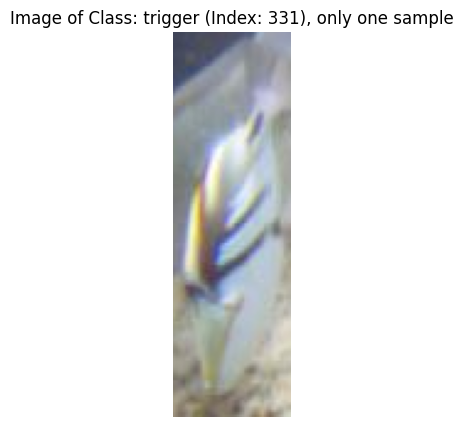

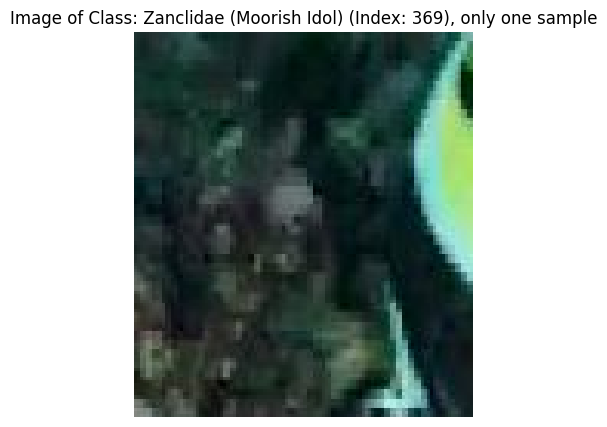

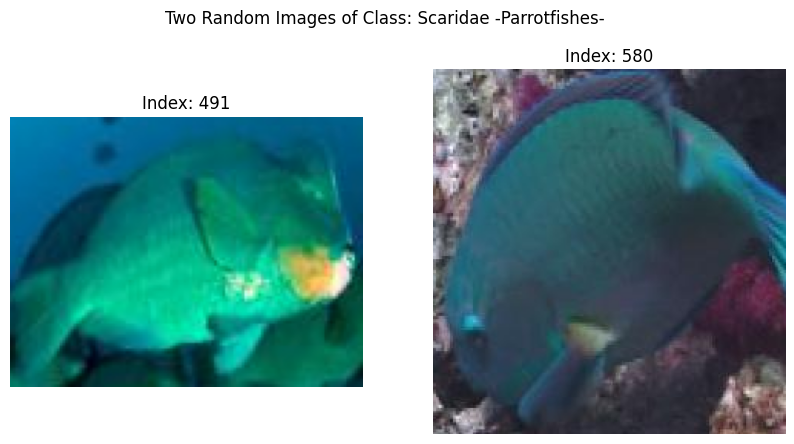

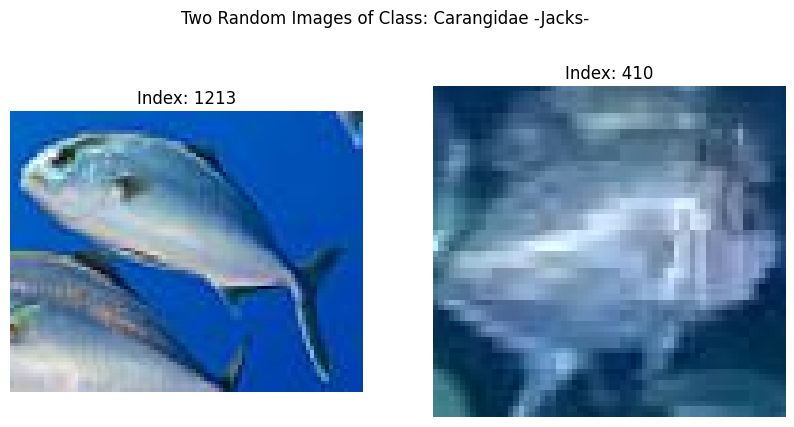

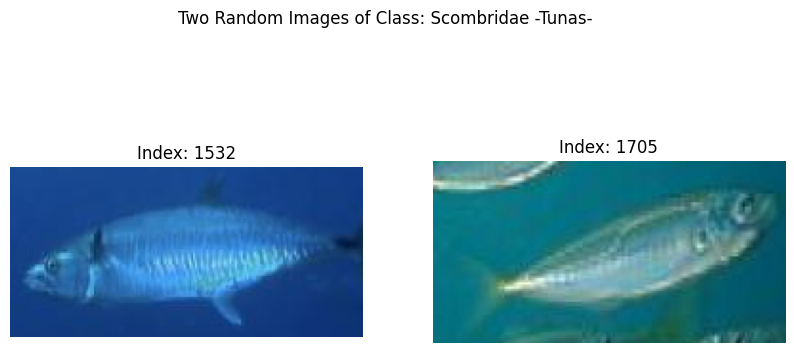

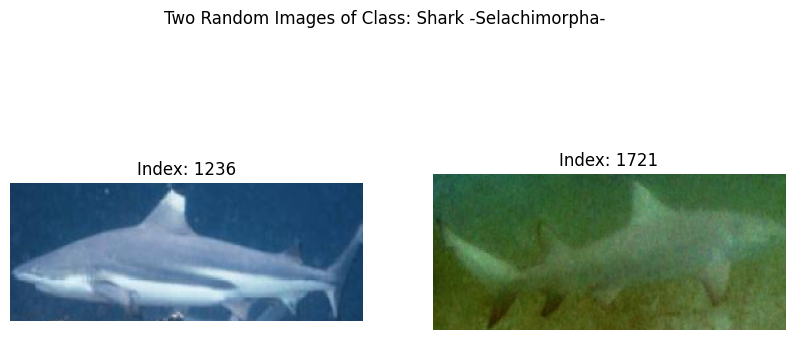

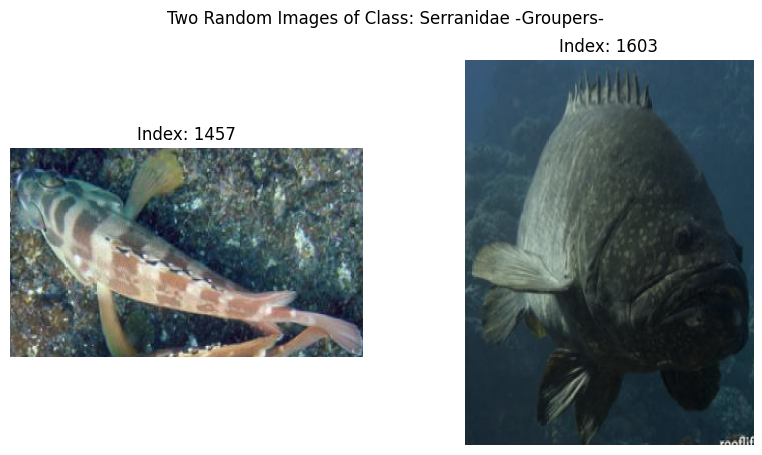

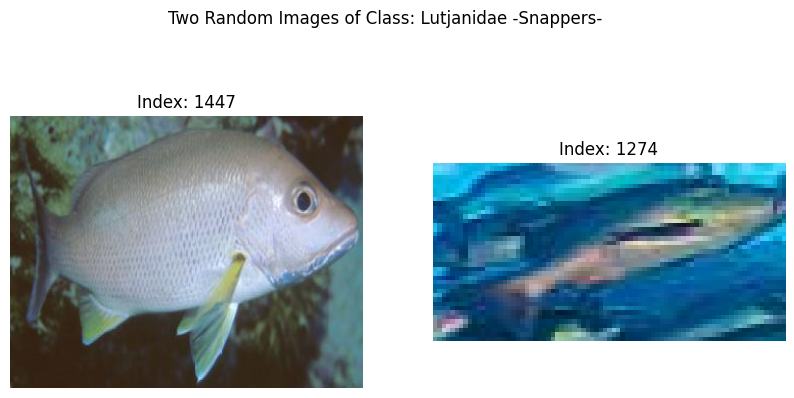

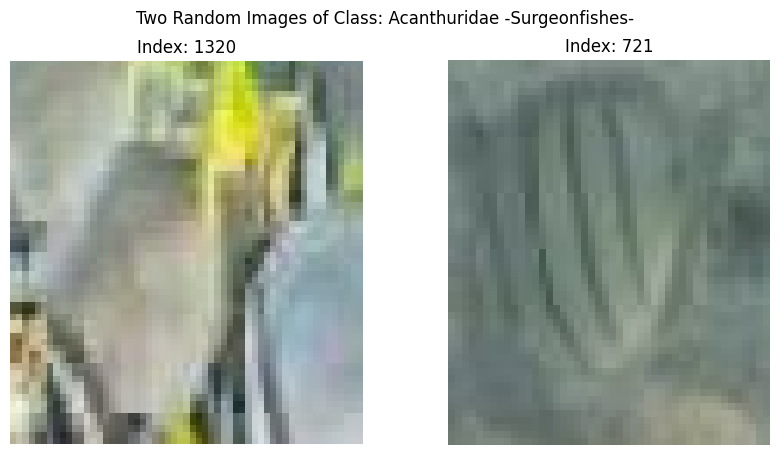

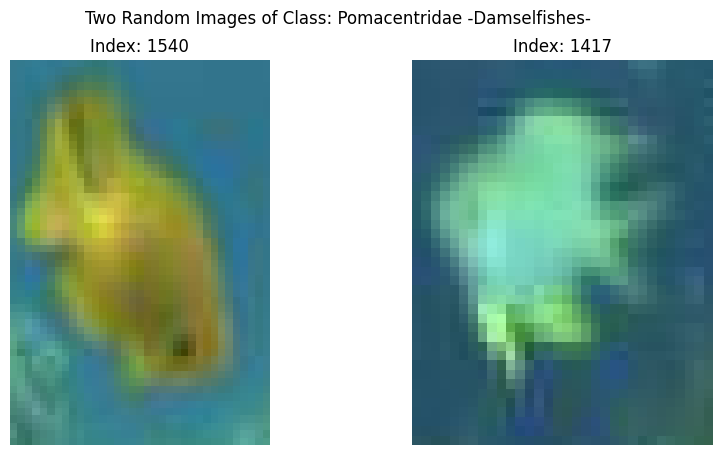

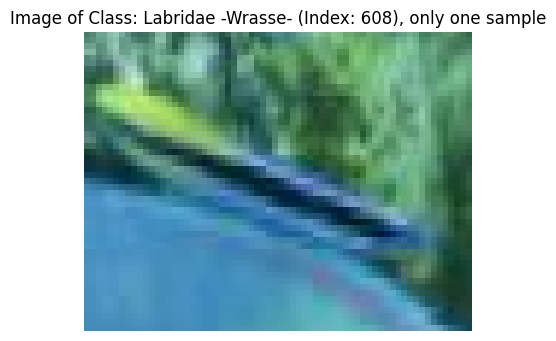

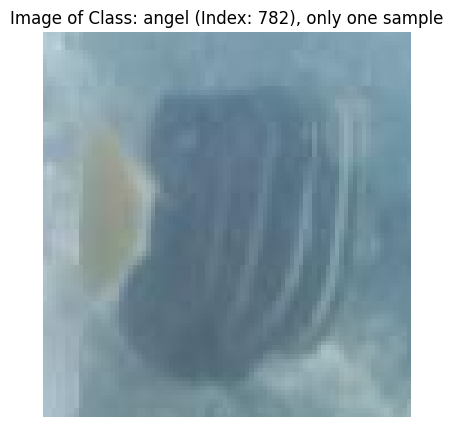

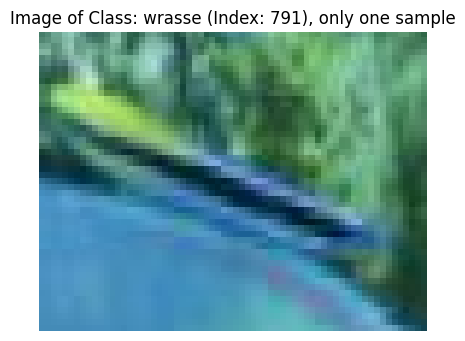

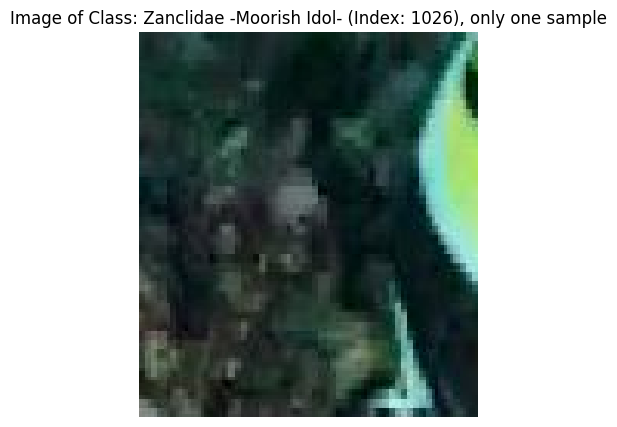

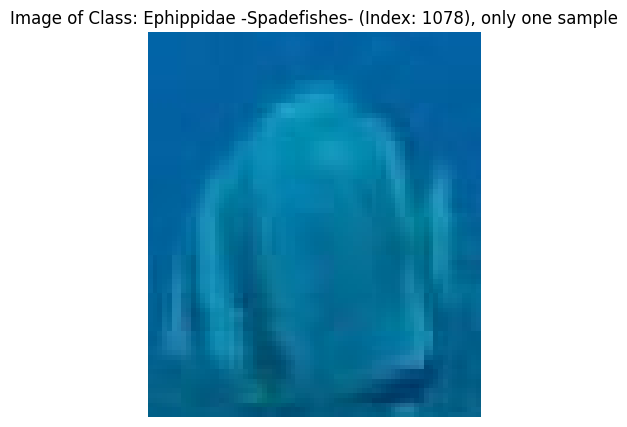

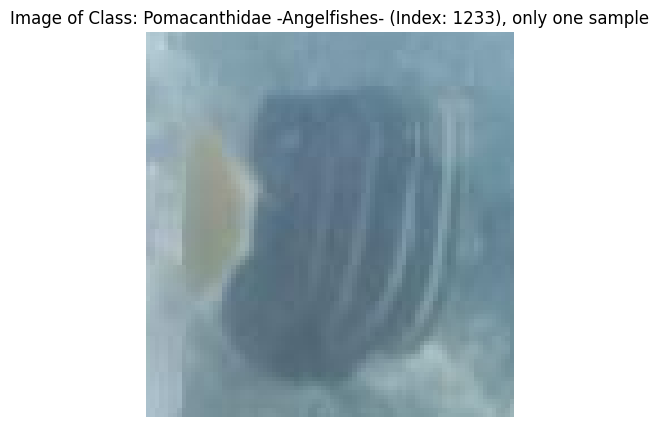

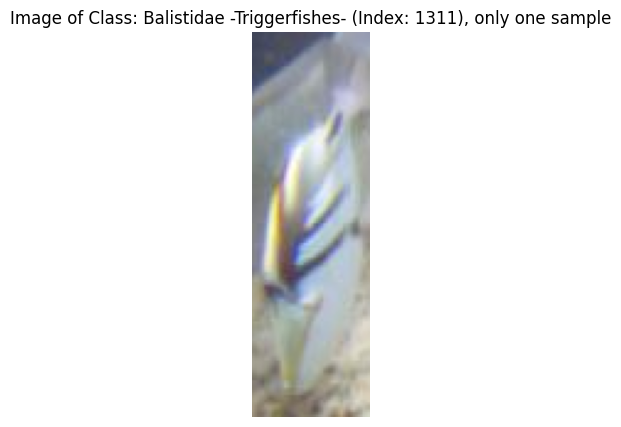

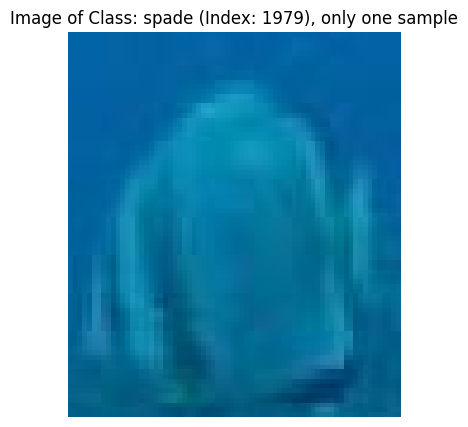

In [4]:
# Read the CSV file into a DataFrame
df_train = pd.read_csv('data/train/_annotations.csv')

# Read and store cropped images
cropped_image_list = []

for index, row in df_train.iterrows():
    image_path = row['filename']
    image = Image.open('data/train/' + image_path)

    # Extract cropping coordinates
    xmin, ymin, xmax, ymax = (
        max(0, row['xmin']),
        max(0, row['ymin']),
        min(image.width, row['xmax']),
        min(image.height, row['ymax'])
    )

    # Check if the adjusted coordinates are valid
    if xmin < xmax and ymin < ymax:
        # Crop the image
        cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax)))

        # Store the cropped image in the list
        cropped_image_list.append(cropped_image)
    else:
        # If the coordinates are invalid, append a placeholder (e.g., None)
        cropped_image_list.append(None)

# Add a new column to the DataFrame with cropped images
df_train['cropped_image'] = cropped_image_list

# Filter out rows with None values in the 'cropped_image' column
df_valid_crops = df_train.dropna(subset=['cropped_image'])

# Display general information
print("Number of valid cropped images:", len(df_valid_crops))
print("Number of proposed images:", len(df_train))
print("Image sizes:")
print(df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts())

# Get unique classes in the DataFrame
unique_classes = df_valid_crops['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_valid_crops[df_valid_crops['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
        
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")


We can see that some of the classes are the same but with different name and that some of the picture are very pixelized. So we are going to do some mapping for the classes and create a function to automate the recuperation of the data. We can also see that due to the cropping the image are all of different size so after we are going to resize them into the same size the biggest one

In [5]:
unique_classes

array(['tuna', 'surgeon', 'shark', 'jack', 'grouper', 'parrot', 'snapper',
       'damsel', 'trigger', 'Zanclidae (Moorish Idol)',
       'Scaridae -Parrotfishes-', 'Carangidae -Jacks-',
       'Scombridae -Tunas-', 'Shark -Selachimorpha-',
       'Serranidae -Groupers-', 'Lutjanidae -Snappers-',
       'Acanthuridae -Surgeonfishes-', 'Pomacentridae -Damselfishes-',
       'Labridae -Wrasse-', 'angel', 'wrasse', 'Zanclidae -Moorish Idol-',
       'Ephippidae -Spadefishes-', 'Pomacanthidae -Angelfishes-',
       'Balistidae -Triggerfishes-', 'spade'], dtype=object)

In [6]:
old_class_to_actual_class = {
    'tuna' : 'tuna', 
    'surgeon': 'surgeon', 
    'shark': 'shark', 
    'jack': 'jack', 
    'grouper': 'grouper', 
    'parrot': 'parrot', 
    'snapper': 'snapper',
    'damsel': 'damsel', 
    'trigger': 'trigger', 
    'Zanclidae (Moorish Idol)': 'moorish idol',
    'Scaridae -Parrotfishes-': 'parrot', 
    'Carangidae -Jacks-': 'jack',
    'Scombridae -Tunas-': 'tuna', 
    'Shark -Selachimorpha-': 'shark',
    'Serranidae -Groupers-': 'grouper', 
    'Lutjanidae -Snappers-': 'snapper',
    'Acanthuridae -Surgeonfishes-': 'surgeon', 
    'Pomacentridae -Damselfishes-': 'damsel',
    'Labridae -Wrasse-': 'wrasse', 
    'angel': 'angel', 
    'wrasse': 'wrasse', 
    'Zanclidae -Moorish Idol-': 'moorish idol',
    'Ephippidae -Spadefishes-': 'spade', 
    'Pomacanthidae -Angelfishes-': 'angel',
    'Balistidae -Triggerfishes-': 'trigger', 
    'spade': 'spade'
}

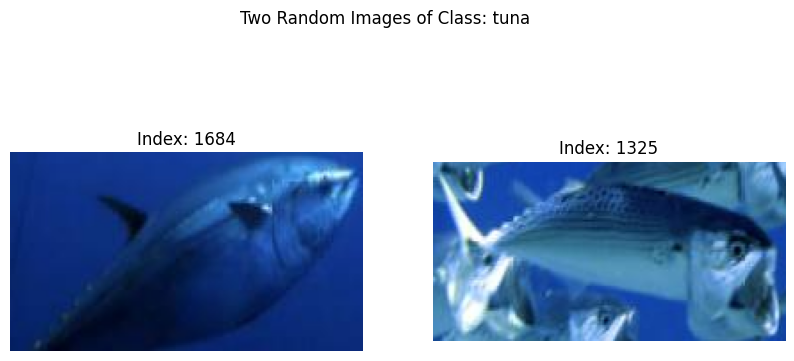

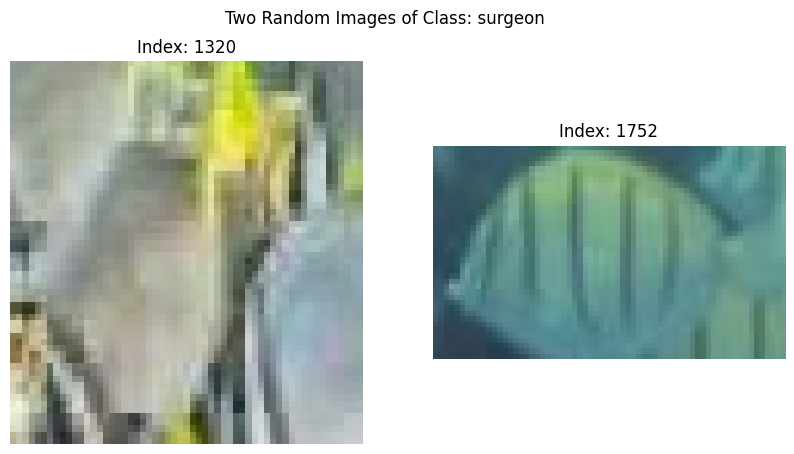

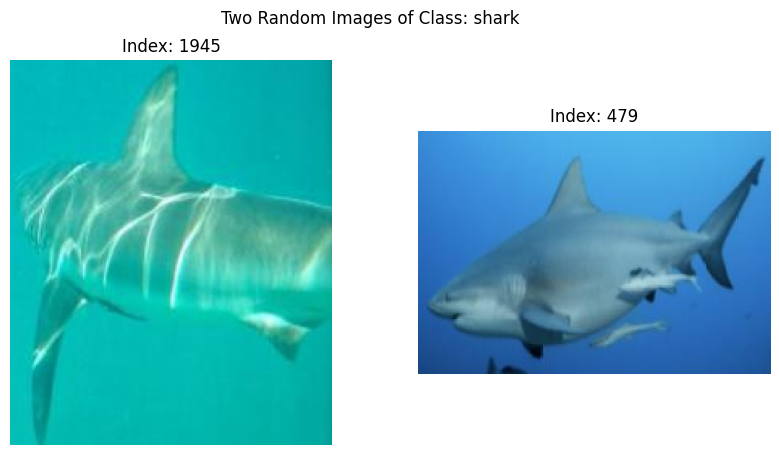

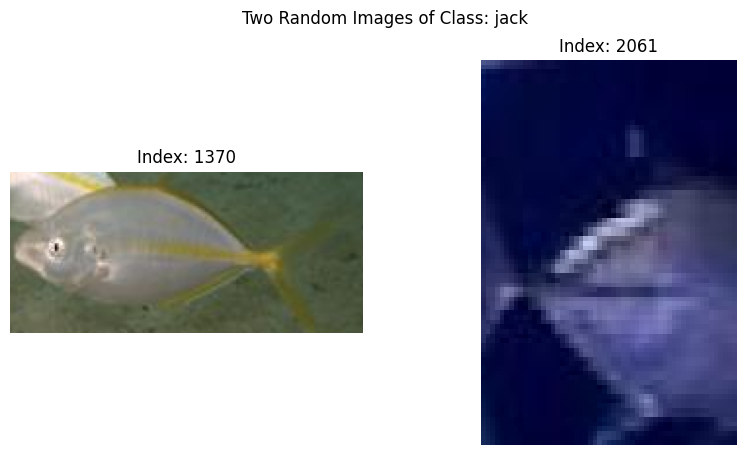

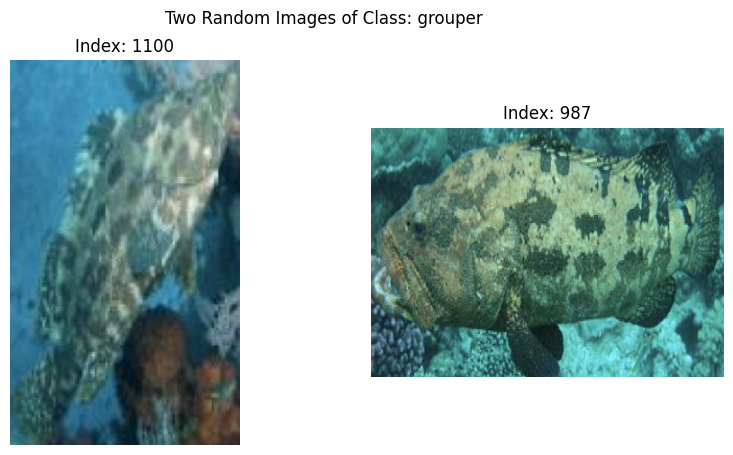

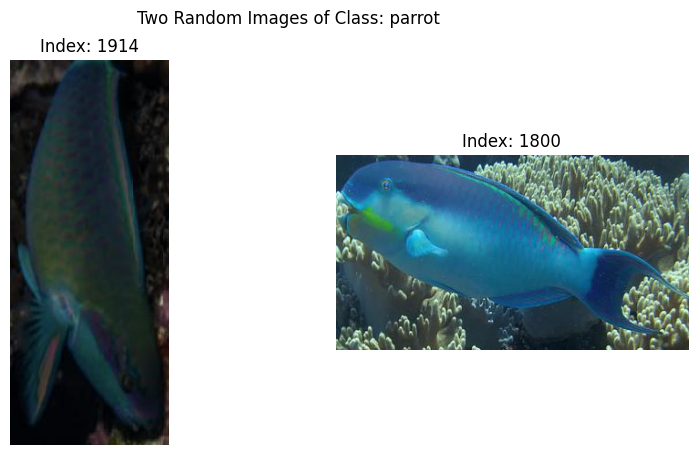

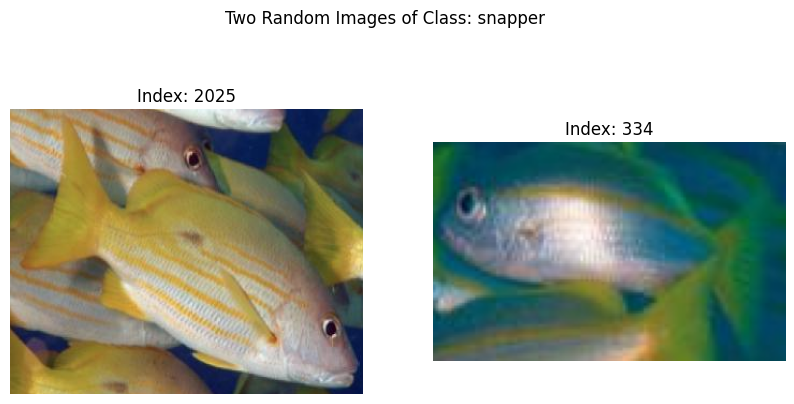

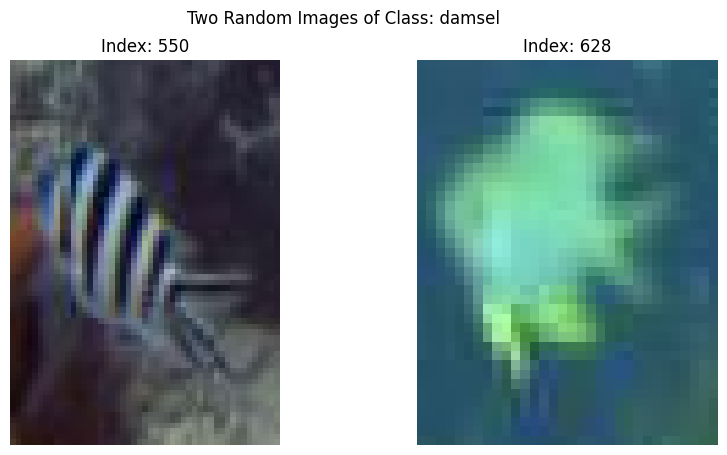

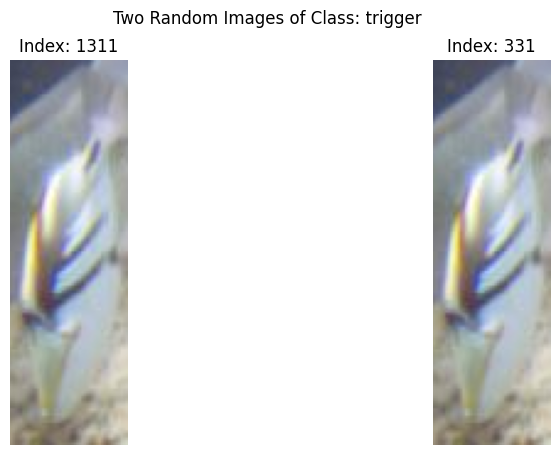

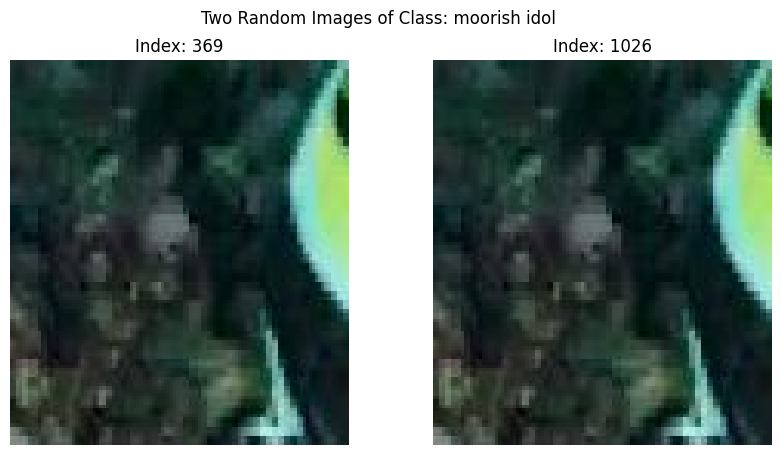

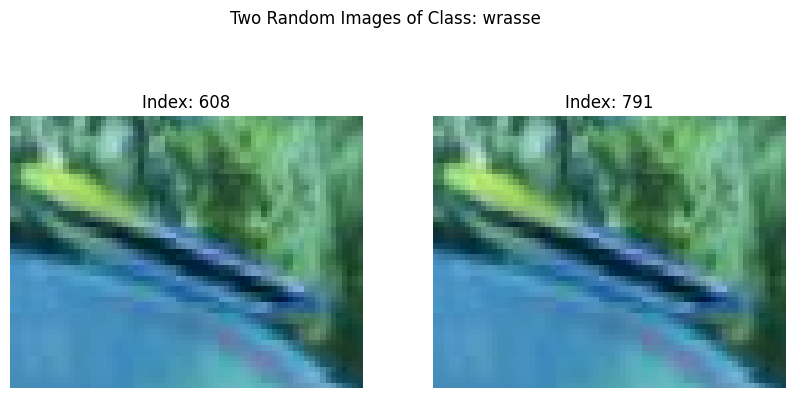

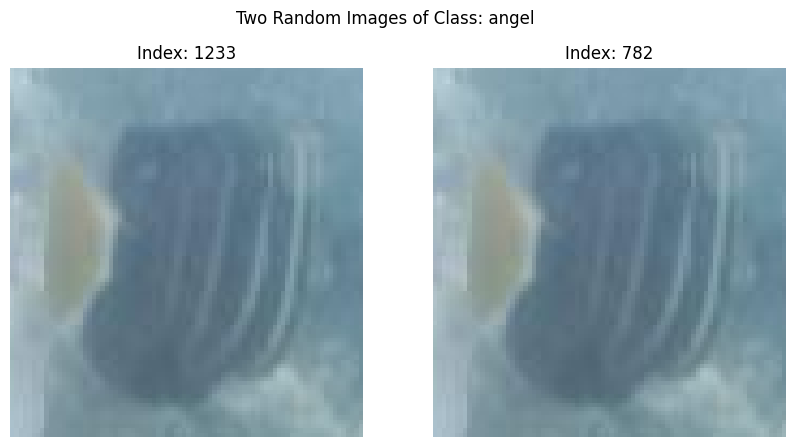

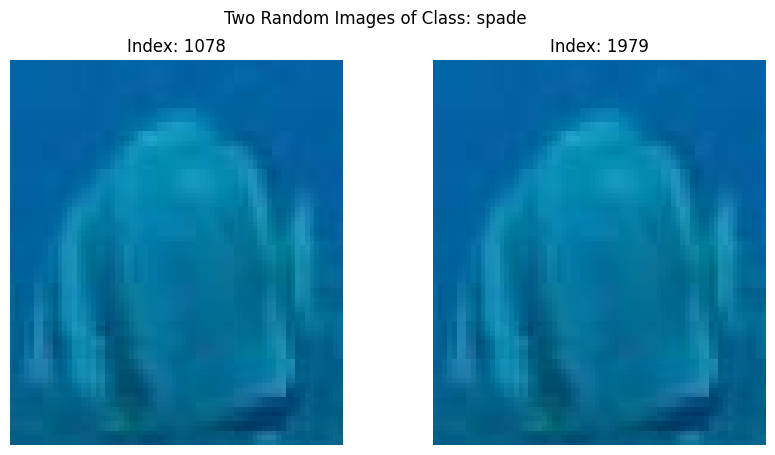

In [7]:
# Copy valid dataframe 
df_new_class = df_valid_crops.copy()

# Replace old class names with new class names
df_new_class['class'] = df_new_class['class'].replace(old_class_to_actual_class)

# Get unique classes in the DataFrame
unique_classes = df_new_class['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_new_class[df_new_class['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")

In [8]:
df_new_class['class'].value_counts()

surgeon         534
jack            376
tuna            333
snapper         299
shark           188
parrot          176
grouper         147
damsel           12
trigger           2
moorish idol      2
wrasse            2
angel             2
spade             2
Name: class, dtype: int64

We can see that there is some of the data which is underreepresented as told in the website 

We are now going to look at the size of the images and reshape them

In [9]:
df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts().sort_index()

(2, 1, 3)        4
(18, 27, 3)      2
(19, 25, 3)      2
(23, 26, 3)      2
(24, 27, 3)      2
                ..
(402, 388, 3)    2
(406, 291, 3)    2
(409, 363, 3)    2
(410, 334, 3)    2
(411, 415, 3)    2
Name: cropped_image, Length: 1023, dtype: int64

In [10]:
# looking at the average image size
index = df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts().sort_index().index

# Convert tuples to arrays
index_as_arrays = np.array([np.array(x) for x in index])

# Transpose the array to have dimensions in the order (height, width, channels)
index_transposed = index_as_arrays.transpose()

# Calculate the average along each dimension
average_size = np.mean(index_transposed, axis=1)

print(average_size)

[137.51808407 171.09384164   3.        ]


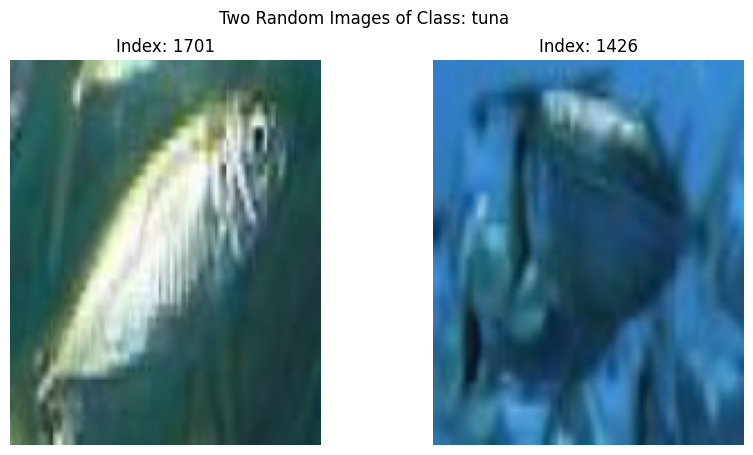

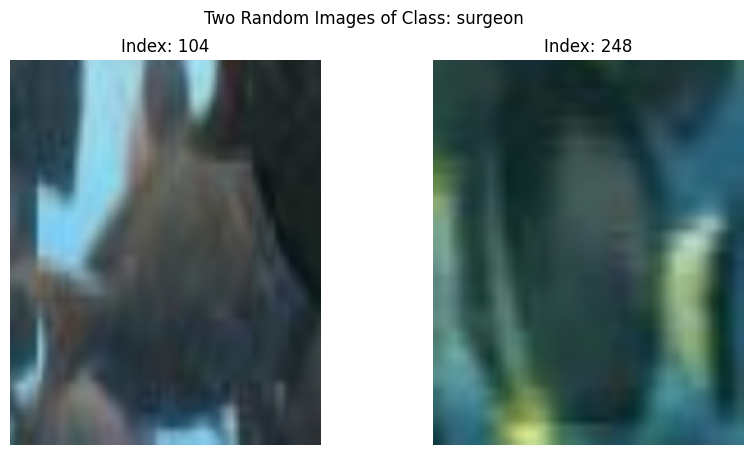

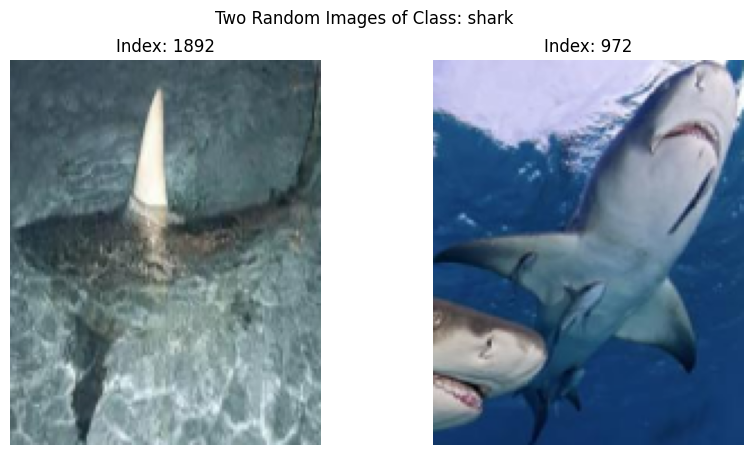

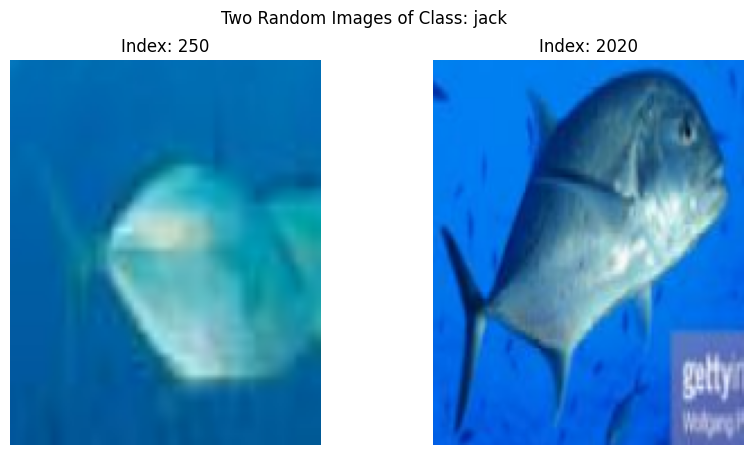

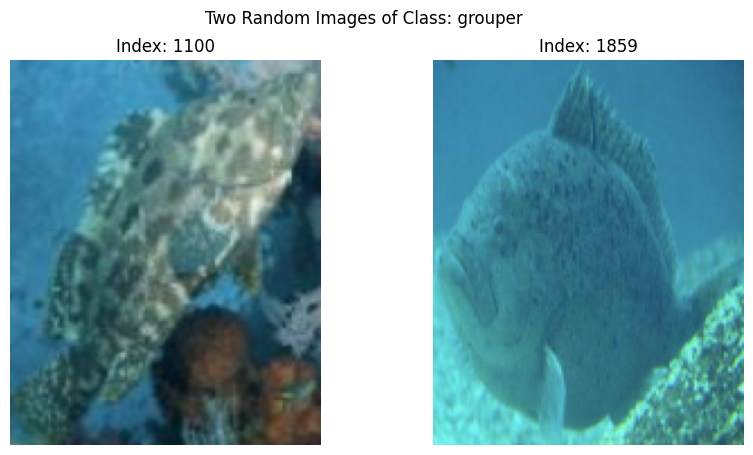

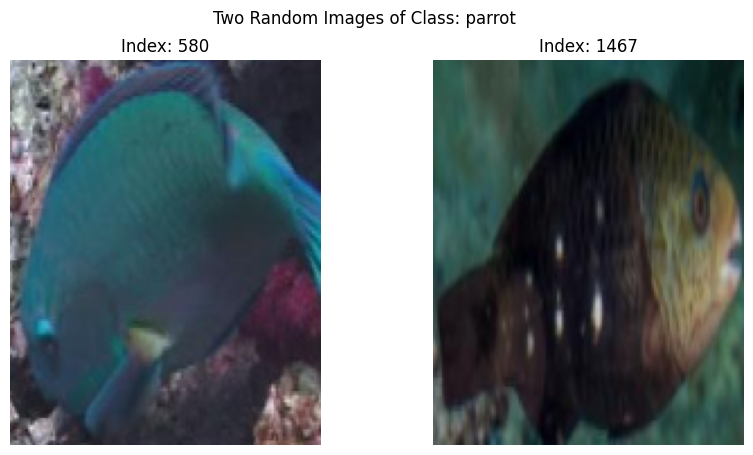

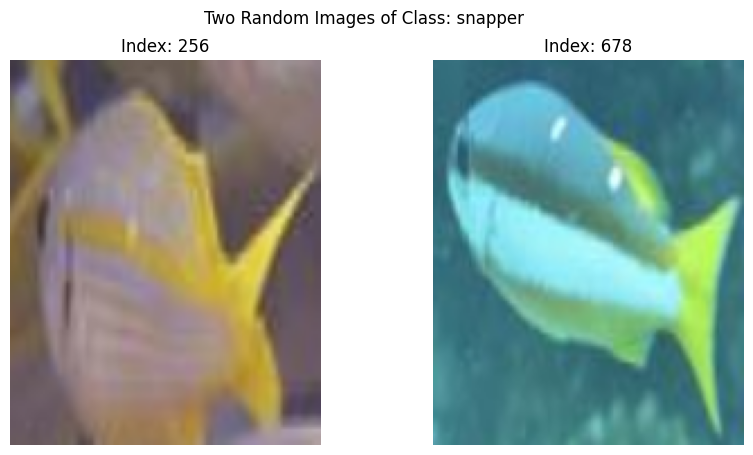

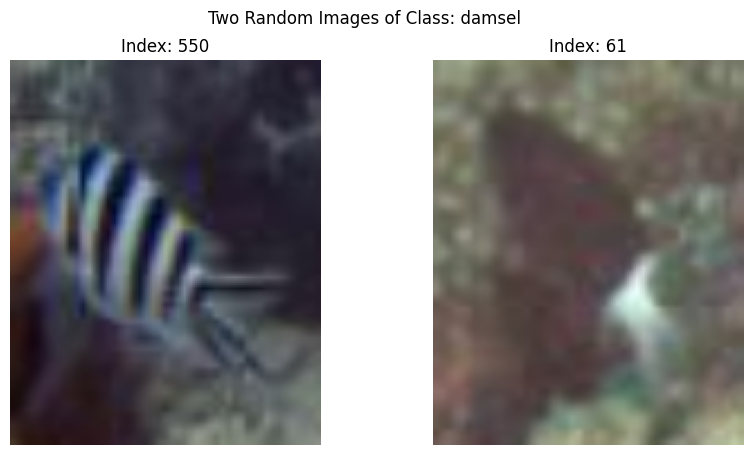

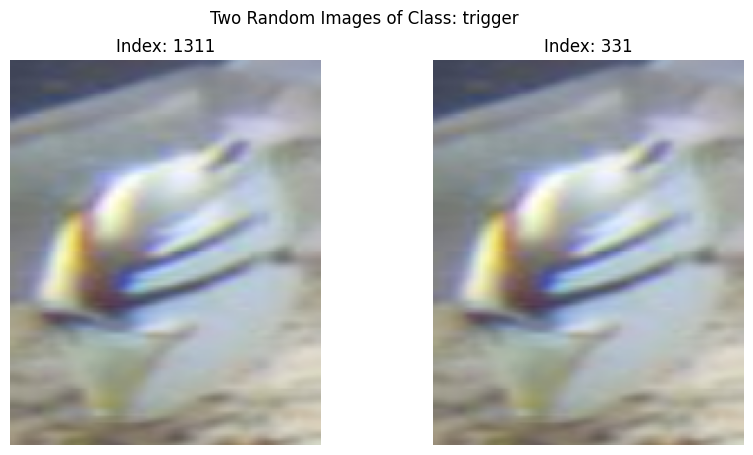

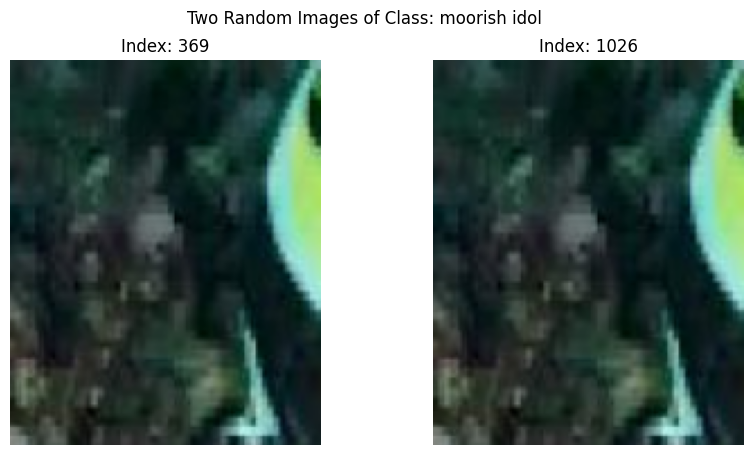

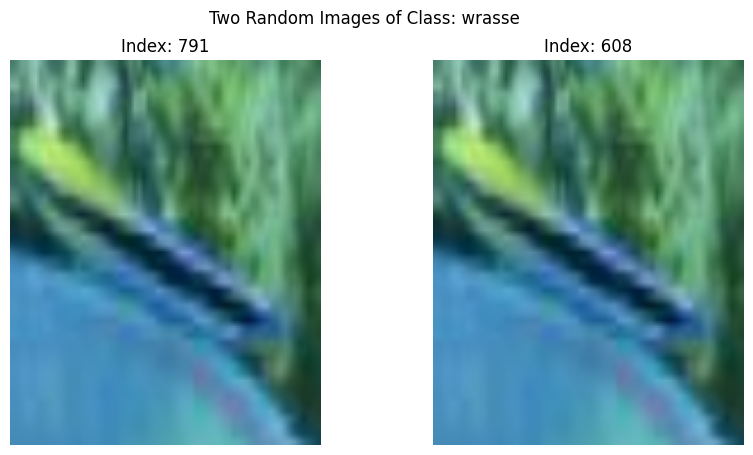

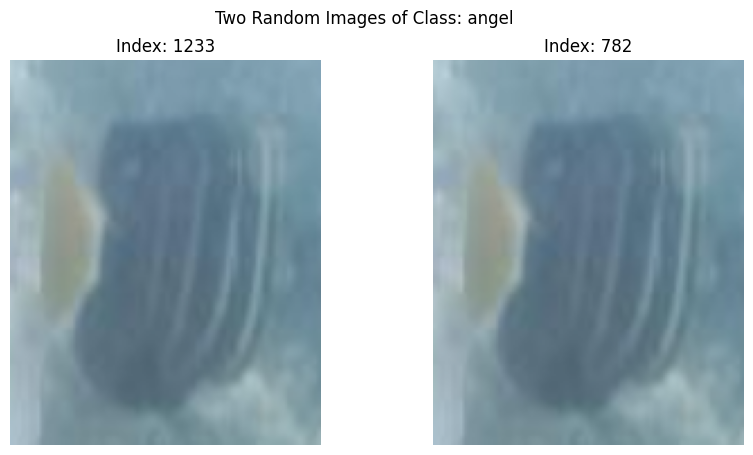

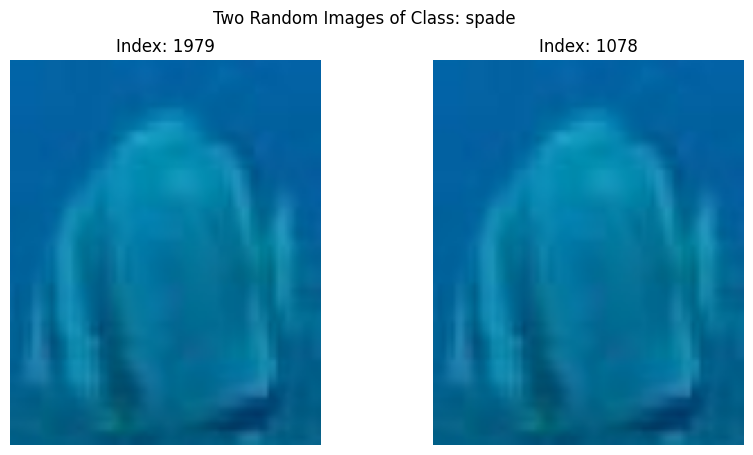

In [11]:
# Define the target size for resizing
target_size = (138, 171)  

# Reshape the images in the 'cropped_image' column
df_new_class['cropped_image'] = df_new_class['cropped_image'].apply(lambda x: cv2.resize(x, target_size) if x is not None else None)

# Get unique classes in the DataFrame
unique_classes = df_new_class['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_new_class[df_new_class['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")

### Functions for crop 

In [12]:
def read_and_crop(path):
    
    # Read the CSV file into a DataFrame
    if path[-1] == '/':
        df = pd.read_csv(path +'_annotations.csv')
    else :
        df = pd.read_csv(path +'/_annotations.csv')

    # Read and store cropped images
    cropped_image_list = []

    for index, row in df.iterrows():
        image_path = row['filename']
        if path[-1] == '/':
            image = Image.open(path + image_path)
        else :
            image = Image.open(path + '/' + image_path)
            

        # Extract cropping coordinates
        xmin, ymin, xmax, ymax = (
            max(0, row['xmin']),
            max(0, row['ymin']),
            min(image.width, row['xmax']),
            min(image.height, row['ymax'])
        )

        # Check if the adjusted coordinates are valid
        if xmin < xmax and ymin < ymax:
            
            # Crop the image
            cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax))) 

            # Reshape the images in the 'cropped_image' column
            cropped_reshape_image = cv2.resize(cropped_image, (171, 138))

            # Store the cropped image in the list
            cropped_image_list.append(cropped_reshape_image)
        else:
            # If the coordinates are invalid, append a placeholder (e.g., None)
            cropped_image_list.append(None)

    # Add a new column to the DataFrame with cropped images
    df['cropped_image'] = cropped_image_list.copy()

    # Filter out rows with None values in the 'cropped_image' column
    df_valid_crops = df.dropna(subset=['cropped_image']).copy()
    
    df_final = df_valid_crops[['class', 'cropped_image']].copy()
    
    # 
    old_class_to_actual_class = {
        'tuna' : 'tuna', 
        'surgeon': 'surgeon', 
        'shark': 'shark', 
        'jack': 'jack', 
        'grouper': 'grouper', 
        'parrot': 'parrot', 
        'snapper': 'snapper',
        'damsel': 'damsel', 
        'trigger': 'trigger', 
        'Zanclidae (Moorish Idol)': 'moorish idol',
        'Scaridae -Parrotfishes-': 'parrot', 
        'Carangidae -Jacks-': 'jack',
        'Scombridae -Tunas-': 'tuna', 
        'Shark -Selachimorpha-': 'shark',
        'Serranidae -Groupers-': 'grouper', 
        'Lutjanidae -Snappers-': 'snapper',
        'Acanthuridae -Surgeonfishes-': 'surgeon', 
        'Pomacentridae -Damselfishes-': 'damsel',
        'Labridae -Wrasse-': 'wrasse', 
        'angel': 'angel', 
        'wrasse': 'wrasse', 
        'Zanclidae -Moorish Idol-': 'moorish idol',
        'Ephippidae -Spadefishes-': 'spade', 
        'Pomacanthidae -Angelfishes-': 'angel',
        'Balistidae -Triggerfishes-': 'trigger', 
        'spade': 'spade'
    }
   
    # Replace old class names with new class names
    df_final['class'] = df_final['class'].replace(old_class_to_actual_class)
    
    return df_final


def print_image_by_classes(df,images_to_plot=2):
    
    # Get unique classes in the DataFrame
    unique_classes = df['class'].unique()

    # Plot two random images for each class
    for class_name in unique_classes:
        # Filter DataFrame based on the current class
        df_same_class = df[df['class'] == class_name]

        # Check the number of images in the current class
        num_images = len(df_same_class)

        if num_images >= images_to_plot:
            # Randomly select two images from the current class
            random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

            # Plot the two random images for the current class
            fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
            fig.suptitle(f'Two Random Images of Class: {class_name}')

            for i, ax in enumerate(axes):
                ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
                ax.set_title(f"Index: {random_indices[i]}")
                ax.axis('off')

            plt.show()
            continue
            
        elif num_images >= 1:
            # Plot the single image for the current class
            plt.figure(figsize=(5, 5))
            plt.imshow(df_same_class.iloc[0]['cropped_image'])
            plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]})')
            plt.axis('off')
            plt.show()
            continue
            
        else:
            print(f"No images of class '{class_name}' for plotting.")
    

In [22]:
# function to ressort the X and y of dataframe
def to_work(df):
    
    class_to_number = {
    'tuna': 0, 
    'surgeon': 1, 
    'shark': 2, 
    'jack': 3, 
    'grouper': 4, 
    'parrot': 5, 
    'snapper': 6,
    'damsel': 7, 
    'trigger': 8, 
    'moorish idol': 9, 
    'wrasse': 10, 
    'angel': 11, 
    'spade': 12
}

    X = np.stack(df['cropped_image'].to_numpy().copy(), axis=0)
    
    # standardize and center data (make my pc crash)
    X = (X / 255) - 0.5
    
    y = df['class'].replace(class_to_number).to_numpy().copy()
    y_cat = to_categorical(y, num_classes=13)  
    
    return X, y, y_cat 

In [14]:
df_train = read_and_crop('data/train/')
df_test = read_and_crop('data/test/')
df_valid = read_and_crop('data/valid/')

### Classification

#### Model creation

In [15]:
def init_model():
    
    # Start by creating a sequential model
    model = models.Sequential()
    
    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same', input_shape=(138, 171, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Second Convolution & MaxPoolingialize
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer
    model.add(layers.Dense(10, activation='relu'))
    # droupout to minimise the overfitting
    model.add(layers.Dropout(0.3))
    ### Last layer - Classification Layer
    model.add(layers.Dense(13, activation='softmax')) # softmax for multiclass classification

    ### Model compilation
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision','Recall'])
    
    return model
    

#### Model's Trainning and Evaluation

In [25]:
# to plot the result
def plot_history(history):
    fig, axs = plt.subplots(4,1, figsize=(10,10))
    
    axs[0].plot(history.history['loss'], color='red', label='train')
    axs[0].plot(history.history['val_loss'], color='blue', label='val')
    axs[0].set_title('Loss')
    axs[0].legend(['train', 'validation'],loc="upper right")
    
    axs[1].plot(history.history['accuracy'], color='red', label='train')
    axs[1].plot(history.history['val_accuracy'], color='blue', label='val')
    axs[1].set_title('Accuracy ')
    axs[1].legend(['train', 'validation'],loc="upper right")

    axs[2].plot(history.history['precision'], color='red', label='train')
    axs[2].plot(history.history['val_precision'], color='blue', label='val')
    axs[2].set_title('Precision ')
    axs[2].legend(['train', 'validation'],loc="upper right")

    axs[3].plot(history.history['recall'], color='red', label='train')
    axs[3].plot(history.history['val_recall'], color='blue', label='val')
    axs[3].set_title('Recall')
    axs[3].legend(['train', 'validation'],loc="upper right")
    

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel='')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    plt.show()

In [23]:
X_train, y_train, y_train_cat = to_work(df_train)
X_test, y_test, y_test_cat = to_work(df_test)
X_val, y_val, y_val_cat = to_work(df_valid)

Warning : Take around 20 min to run

------------------------------------------Batch Size 4------------------------------------------


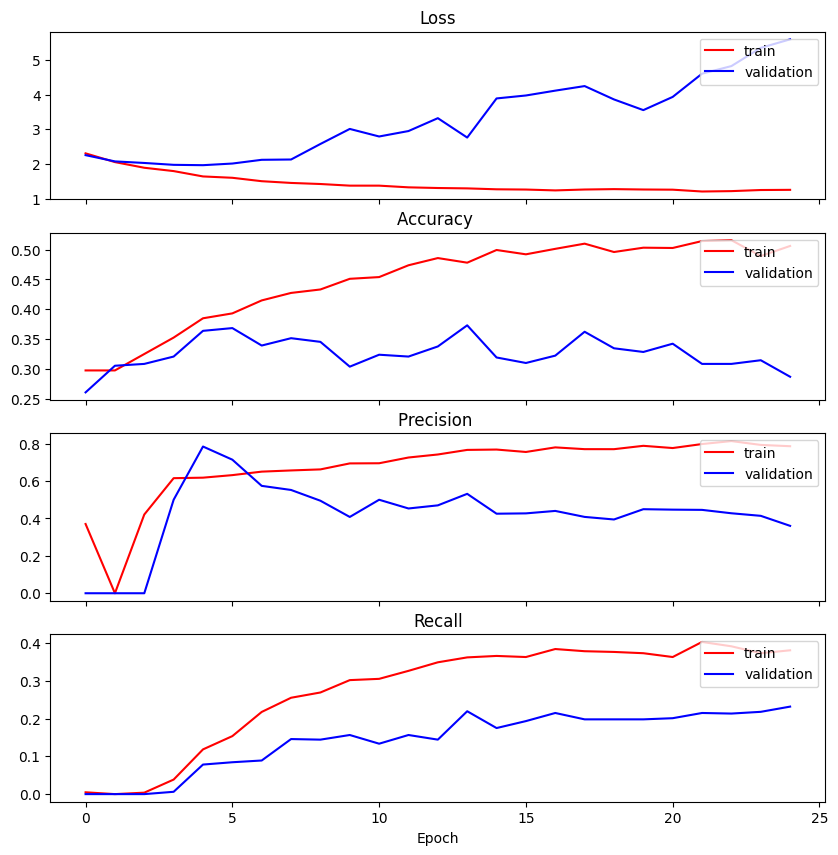

         Model Evaluation on Training :
     Training Loss:     1.4504443407058716
   Training Accuracy:   0.4703614413738251
  Training Precision:   0.8473895788192749
    Training Recall:    0.1016867458820343 

         Model Evaluation on Test :
    Validation Loss:    1.9662898778915405
  Validation Accuracy:  0.3640553057193756
 Validation Precision:  0.7846153974533081
   Validation Recall:   0.07834101468324661
------------------------------------------Batch Size 16------------------------------------------


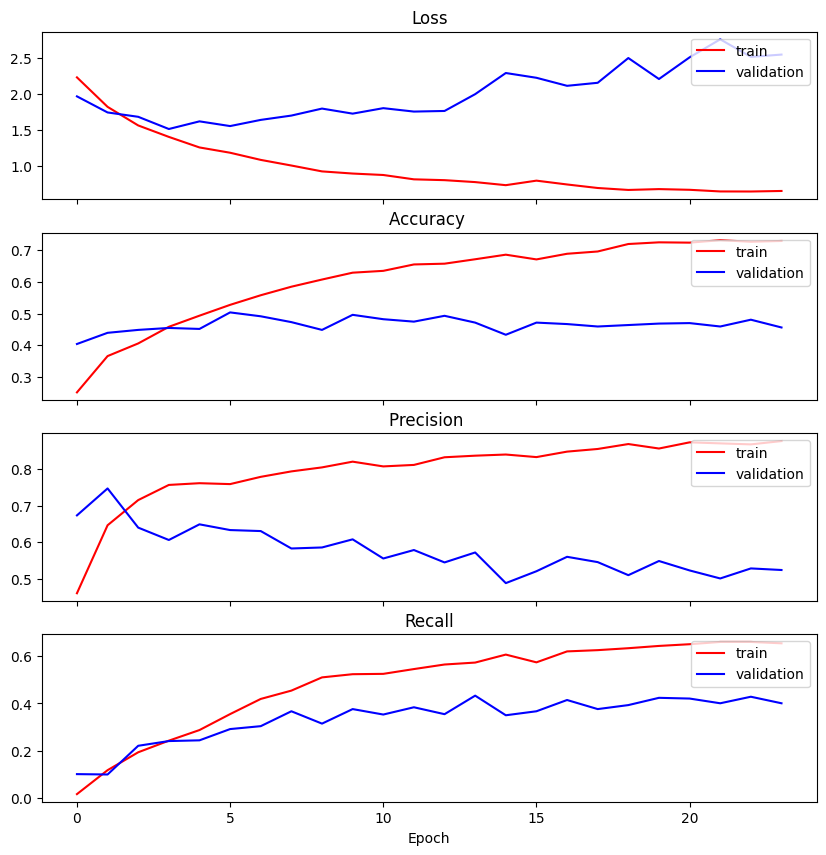

         Model Evaluation on Training :
     Training Loss:     1.0598398447036743
   Training Accuracy:   0.6120482087135315
  Training Precision:   0.8606741428375244
    Training Recall:    0.3691566288471222 

         Model Evaluation on Test :
    Validation Loss:    1.5134773254394531
  Validation Accuracy:  0.4546850919723511
 Validation Precision:  0.6061776280403137
   Validation Recall:   0.24116744101047516
------------------------------------------Batch Size 32------------------------------------------


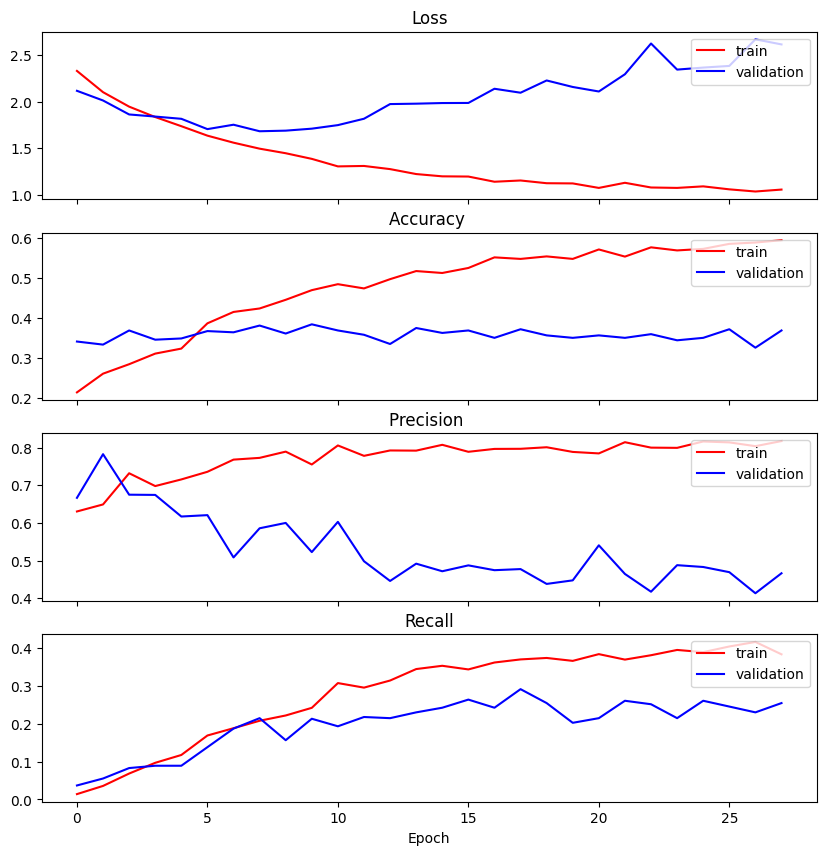

         Model Evaluation on Training :
     Training Loss:     1.1089476346969604
   Training Accuracy:   0.6371084451675415
  Training Precision:   0.8862612843513489
    Training Recall:    0.3792771100997925 

         Model Evaluation on Test :
    Validation Loss:    1.68307626247406
  Validation Accuracy:  0.380952388048172
 Validation Precision:  0.5857740640640259
   Validation Recall:   0.2150537669658661
------------------------------------------Batch Size 64------------------------------------------


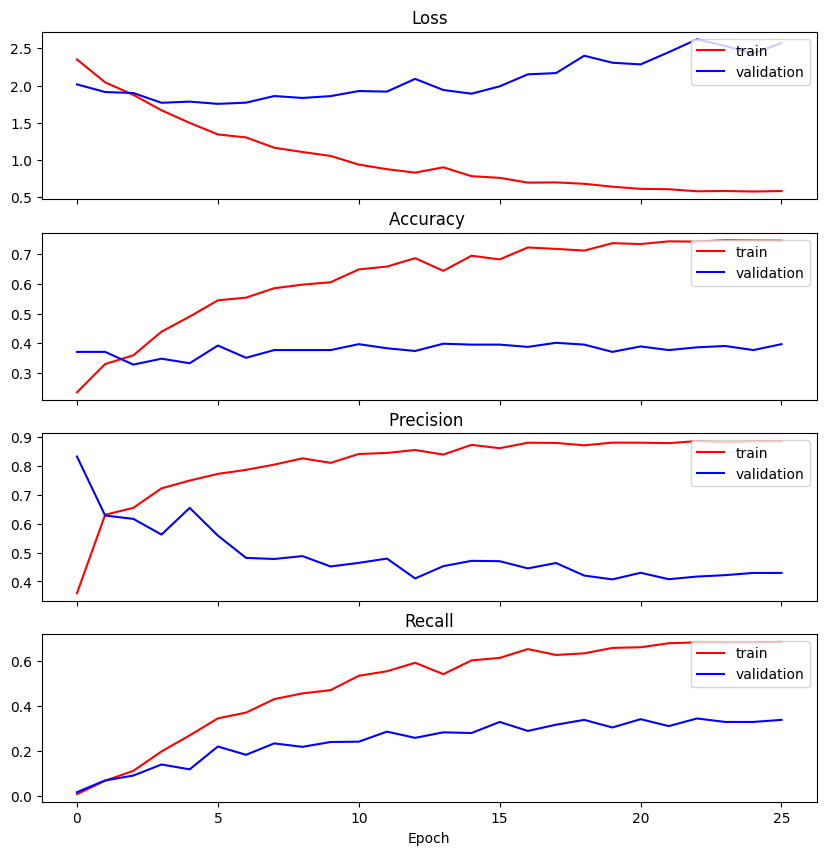

         Model Evaluation on Training :
     Training Loss:     1.0625073909759521
   Training Accuracy:   0.6703614592552185
  Training Precision:   0.8776844143867493
    Training Recall:    0.45301204919815063 

         Model Evaluation on Test :
    Validation Loss:    1.753288984298706
  Validation Accuracy:  0.39170506596565247
 Validation Precision:  0.5590550899505615
   Validation Recall:   0.21812595427036285
------------------------------------------Batch Size 128------------------------------------------


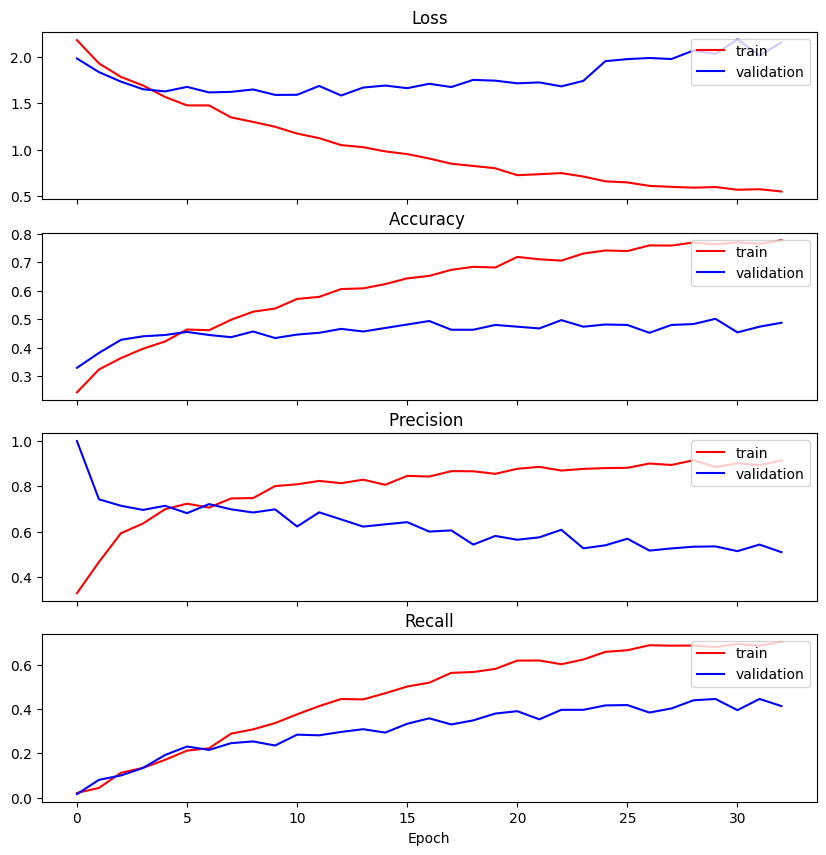

         Model Evaluation on Training :
     Training Loss:     0.7129166722297668
   Training Accuracy:   0.7956626415252686
  Training Precision:   0.9323254227638245
    Training Recall:    0.6240963935852051 

         Model Evaluation on Test :
    Validation Loss:    1.5821216106414795
  Validation Accuracy:  0.46543779969215393
 Validation Precision:  0.6542372703552246
   Validation Recall:   0.29646697640419006
------------------------------------------Batch Size 256------------------------------------------


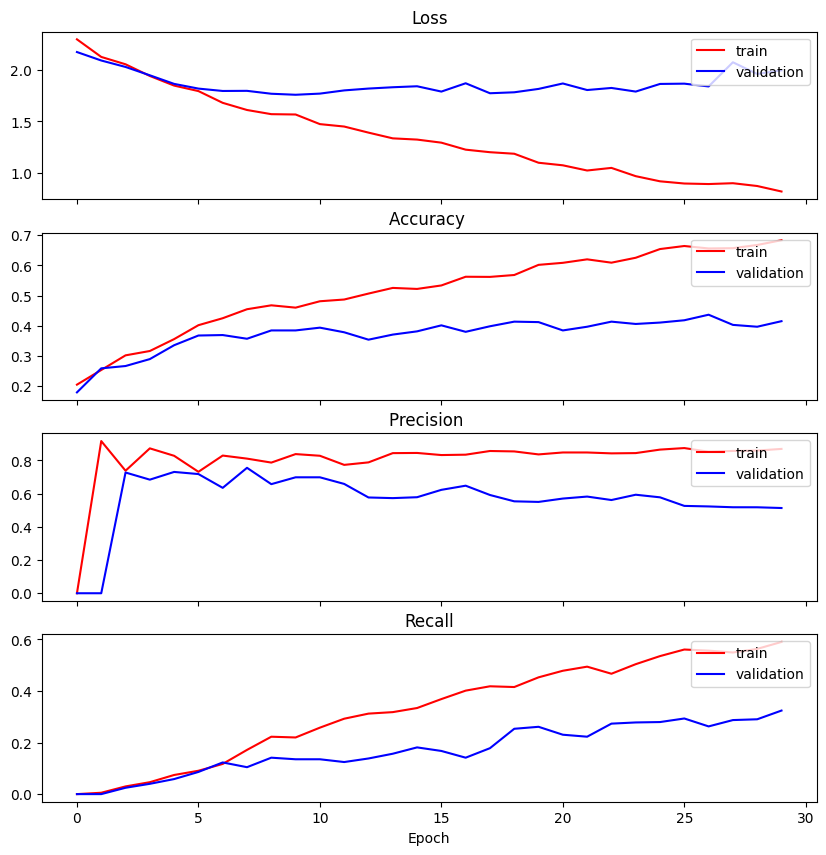

         Model Evaluation on Training :
     Training Loss:     1.2472972869873047
   Training Accuracy:   0.6351807117462158
  Training Precision:   0.9066147804260254
    Training Recall:    0.22457830607891083 

         Model Evaluation on Test :
    Validation Loss:    1.758129358291626
  Validation Accuracy:  0.38402459025382996
 Validation Precision:  0.6984127163887024
   Validation Recall:   0.1351766586303711


In [38]:
# to save the models & the metrics
models_cnn = {}

# early stopping critera
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch in [4,16,32,64,128,256] :
    
    model = init_model()
    
    history = model.fit(
        X_train,
        y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs = 100,
        batch_size = batch, 
        verbose = 0, 
        callbacks = [es]
    )
    
    print(f'------------------------------------------Batch Size {batch}------------------------------------------')
    
    # store the model
    models_cnn[batch] = model
        
    # plot the history of loss and accuracy
    plot_history(history)
    
    # print the evaluation of the model:
    trainEval = model.evaluate(X_train,y_train_cat, verbose=0)
    valEval = model.evaluate(X_val,y_val_cat, verbose=0)

    print("         Model Evaluation on Training :")
    print("     Training Loss:    ", trainEval[0])
    print("   Training Accuracy:  ", trainEval[1])
    print("  Training Precision:  ", trainEval[2])
    print("    Training Recall:   ", trainEval[3], '\n')
    print("         Model Evaluation on Validation :")
    print("    Validation Loss:   ", valEval[0])
    print("  Validation Accuracy: ", valEval[1])
    print(" Validation Precision: ", valEval[2])
    print("   Validation Recall:  ", valEval[3])


We can see for all of the test that the validation loss is going up as if the model is overfitting but most of time precision, recall and accuracy are going up or for batch size 128, 16 and 4 the precision is goind down but the recall is going up with the epochs. The overfitting may be caused by the underbalanced data in the training and validation. We can also see that the model with the best results is the model trained with a batch size of 

## 2) Transfer Learning